In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib.ticker import FuncFormatter
import pandas as pd




In [2]:
df = pd.read_csv('data/kickstarter_projects.csv')

In [3]:
def prepare_data(dataframe):
    dataframe_new = dataframe.copy()
    # extract duration
    dataframe_new["Launched"] = pd.to_datetime(dataframe_new["Launched"])
    dataframe_new["Deadline"] = pd.to_datetime(dataframe_new["Deadline"])
    dataframe_new["Duration_days"] = (dataframe_new["Deadline"] - dataframe_new["Launched"]).dt.days
    # extract month / year
    dataframe_new["Month"] = dataframe_new["Launched"].dt.month
    # drop 'State' == 'Other' (Canceled, Suspended and Live)
    dataframe_new = dataframe_new.query("State == 'Successful' or State == 'Failed'")
    # drop specific categories (?)
    # dataframe_new = dataframe_new.query("Category != '...' and Category != '...'")
    # Combine 'Category' and 'Subcategory' (to not loose correlation)
    dataframe_new["Combined_category"] = df["Category"] + " - " + df["Subcategory"]
    categories = ["Category", "Subcategory", "Country", "State", "Combined_category"]
    dataframe_new[["Category", "Subcategory", "Country", "State", "Combined_category"]] = \
        dataframe_new[["Category", "Subcategory", "Country", "State", "Combined_category"]].astype("category")
    # 0 < Goal < 10_000_000
    dataframe_new = dataframe_new.query("0 < Goal < 100_000")
    # Pledged > 0
    dataframe_new = dataframe_new.query("Pledged > 0")
    # implement Name: len
    # dataframe_new["Name_length"] = dataframe_new["Name"].str.len()
    dataframe_new['Name_word_count'] = dataframe_new['Name'].str.split().apply(len)
    # concentrate on specific region (?)
    # dataframe_new = dataframe_new.query("Country != 'United States'")

    # Years: 2012 - 2018
    dataframe_new = dataframe_new[dataframe_new["Launched"].dt.year >= 2012]
    
    dataframe_new = dataframe_new.drop(["ID", "Launched", "Deadline", "Category", "Subcategory"], axis=1)
    
    return dataframe_new

In [4]:
ks = prepare_data(df)

/var/folders/bf/sffgn3cj09b7w9m9tzcwtpdc0000gn/T/ipykernel_42322/4222540115.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_new["Combined_category"] = df["Category"] + " - " + df["Subcategory"]
/var/folders/bf/sffgn3cj09b7w9m9tzcwtpdc0000gn/T/ipykernel_42322/4222540115.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_new[["Category", "Subcategory", "Country", "State", "Combined_category"]] = \
/var/folders/bf/sffgn3cj09b7w9m9tzcwtpdc0000gn/T/ipykernel_42322/4222540115.py:24: Set

In [5]:
ks.head()

,Name,Country,Goal,Pledged,Backers,State,Duration_days,Month,Combined_category,Name_word_count
38084,Introspective,United States,4000,5116,37,Successful,15,1,Art - Art,1
38085,Student Doc about attending Sundance Film Fest...,United States,300,367,13,Successful,13,1,Film & Video - Documentary,7
38087,BOARDED project,United States,2345,3251,65,Successful,44,1,Art - Art,2
38088,THE CITY TROLL: a graphic novel,United States,2000,6311,202,Successful,37,1,Comics - Comics,6
38089,California Brewing Company: Bringing jobs & be...,United States,48000,1931,19,Failed,44,1,Food - Food,9


In [6]:
ks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 251831 entries, 38084 to 374605
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Name               251831 non-null  object  
 1   Country            251831 non-null  category
 2   Goal               251831 non-null  int64   
 3   Pledged            251831 non-null  int64   
 4   Backers            251831 non-null  int64   
 5   State              251831 non-null  category
 6   Duration_days      251831 non-null  int64   
 7   Month              251831 non-null  int32   
 8   Combined_category  251831 non-null  category
 9   Name_word_count    251831 non-null  int64   
dtypes: category(3), int32(1), int64(5), object(1)
memory usage: 15.4+ MB


### RESEACH QUESTIONS:

1. Is the success of a campaign depending on the country?
2. Is the success of a campaign depending on the category?
3. Is the success of a campaign depending on the month of launching?
4. Is the success of a campaign depending on the duration of the campaign?
5. Is the success of a campaign depending on the Name?

<br>

### HYPOTHESIS:

1. If started in US, then more money is raised.
2. If category is technology, then the campaign is more likely to succeed.
3. If the campaign is launched in September, the success rate is higher.
4. If you set your duration lower than 30 days (default) than your success rate improves.
5. The catchier and shorter the name, the higher the success rate.


---

1. Success vs. Country

In [7]:
df.head()

,ID,Name,Category,Subcategory,Country,Launched,Deadline,Goal,Pledged,Backers,State
0,1860890148,Grace Jones Does Not Give A F$#% T-Shirt (limi...,Fashion,Fashion,United States,2009-04-21 21:02:48,2009-05-31,1000,625,30,Failed
1,709707365,CRYSTAL ANTLERS UNTITLED MOVIE,Film & Video,Shorts,United States,2009-04-23 00:07:53,2009-07-20,80000,22,3,Failed
2,1703704063,drawing for dollars,Art,Illustration,United States,2009-04-24 21:52:03,2009-05-03,20,35,3,Successful
3,727286,Offline Wikipedia iPhone app,Technology,Software,United States,2009-04-25 17:36:21,2009-07-14,99,145,25,Successful
4,1622952265,Pantshirts,Fashion,Fashion,United States,2009-04-27 14:10:39,2009-05-26,1900,387,10,Failed


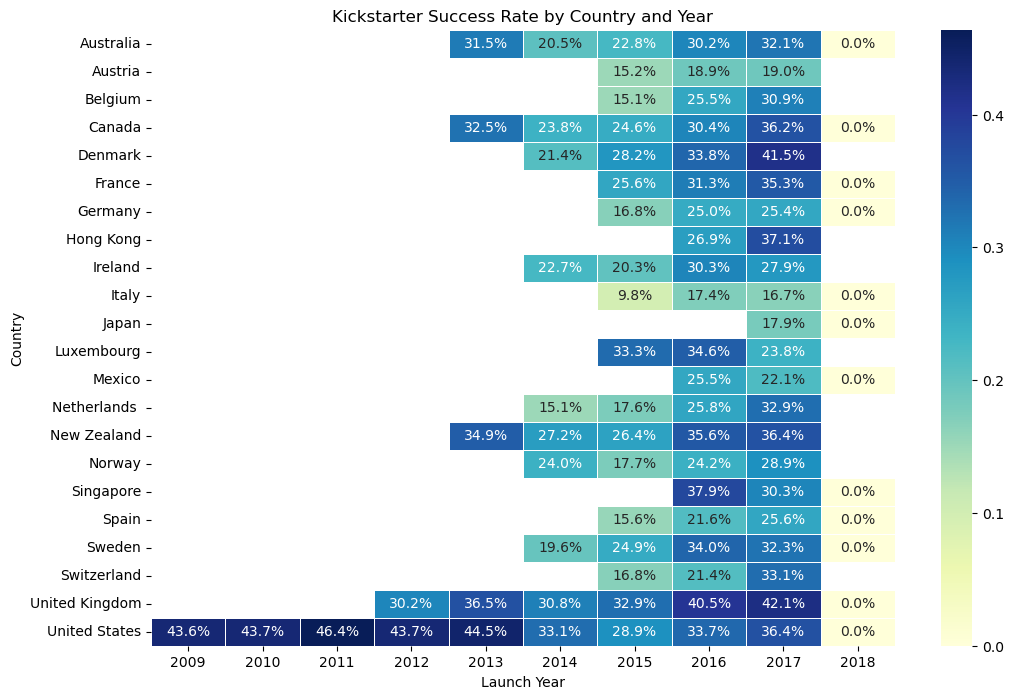

In [8]:
# SUCCESS RATE per country and year

df['Launched'] = pd.to_datetime(df['Launched'], format='%Y-%m-%d %H:%M:%S')
df['Deadline'] = pd.to_datetime(df['Deadline'], format='%Y-%m-%d')

# calculate the time difference between 'deadline' and 'launched' in days
df['Duration'] = (df['Deadline'] - df['Launched']).dt.days

# Convert date columns to datetime
df['Launched'] = pd.to_datetime(df['Launched'])
df['Deadline'] = pd.to_datetime(df['Deadline'])

# Extract the year from Launched
df['Launch_Year'] = df['Launched'].dt.year

# Calculate success rate
# Define successful projects
df['Is_Successful'] = df['State'] == 'Successful'

# Group by Country and Launch_Year and calculate success rate
success_rate_by_country_year = df.groupby(['Country', 'Launch_Year'])['Is_Successful'].mean().reset_index()

# Create a pivot table
pivot_table = success_rate_by_country_year.pivot_table(index='Country', columns='Launch_Year', values='Is_Successful', aggfunc='mean')

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt=".1%", linewidths=.5)
plt.title('Kickstarter Success Rate by Country and Year')
plt.xlabel('Launch Year')
plt.ylabel('Country')
plt.show()

2. Success vs. Category

<Figure size 1200x800 with 0 Axes>

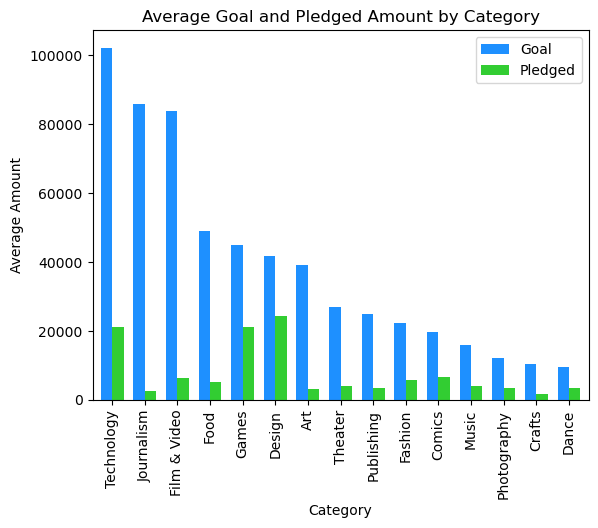

In [9]:
# AVERAGE GOAL VS. PLEDGED PER CATEGORY

# Group by Category and calculate the mean of the 'Goal' and 'Pledged' columns
goal_pledged_by_category = df.groupby('Category')[['Goal', 'Pledged']].mean()

# Sort the values to display in a more meaningful order
goal_pledged_by_category = goal_pledged_by_category.sort_values(by='Goal', ascending=False)

# Plot the goal and pledged amounts by category
plt.figure(figsize=(12, 8))
ax = goal_pledged_by_category.plot(kind='bar', color=['dodgerblue', 'limegreen'], width=0.7, position=0.5)

plt.title('Average Goal and Pledged Amount by Category')
plt.xlabel('Category')
plt.ylabel('Average Amount')
plt.xticks(rotation=90)
plt.legend(['Goal', 'Pledged'])
plt.show()

<Figure size 1000x500 with 0 Axes>

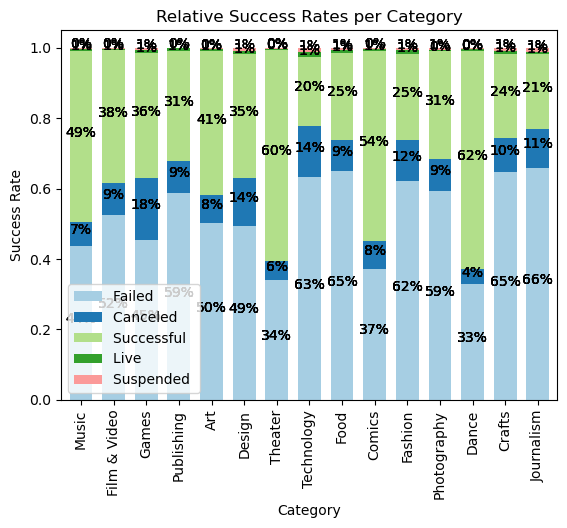

In [10]:
# RELATIVE SUCCESS RATE PER CATEGORY

states = ['Failed', 'Canceled', 'Successful', 'Live', 'Suspended']

# Create a pivot table to calculate the relative success rate per category
pivot_table = df.pivot_table(index='Category', columns='State', aggfunc='size', fill_value=0)

# Calculate the total counts per category
pivot_table['Total'] = pivot_table.sum(axis=1)

# Calculate the relative success rate (Successful / Total) for each state
for state in states:
    pivot_table[f'{state} '] = pivot_table[state] / pivot_table['Total']

# Sort the categories by the success rate of 'Successful' state
sorted_categories = pivot_table['Successful'].sort_values(ascending=False).index
pivot_table = pivot_table.reindex(sorted_categories)

# Plot the relative success rates per category for all states
plt.figure(figsize=(10, 5))
colors = plt.cm.Paired(range(len(pivot_table)))
# Show the legend with a white background
ax = pivot_table[[f'{state} ' for state in states]].plot(kind='bar', stacked=True, color=colors, width=0.7)
plt.title('Relative Success Rates per Category')
plt.xlabel('Category')
plt.ylabel('Success Rate')
plt.xticks(rotation=90)

# Annotate the bars with percentage values
for state in states:
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        success_rate = p.get_height()
        ax.annotate(f'{success_rate*100:.0f}%', (x + width / 2, y + height / 2), ha='center')

# Enable legend with white background
ax.legend()
ax.get_legend().set_frame_on(True)

plt.show()

3. Succes vs. Month of Launch

4. Success vs. Duration

5. Success vs. Name

In [11]:
ks['Name_word_count'].nunique()

22

In [12]:
ks['Name_word_count'].unique()

array([ 1,  7,  2,  6,  9,  5,  8, 11,  4,  3, 10, 12, 13, 14, 15, 17, 19,
       16, 27, 21, 18, 29])

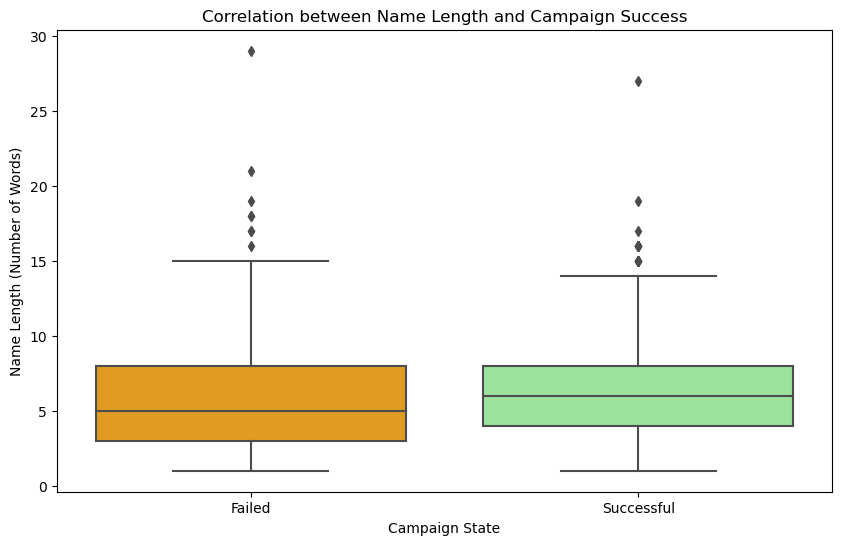

In [25]:
custom_palette = {"Failed": "orange", "Successful": "lightgreen"}

plt.figure(figsize=(10, 6))
sns.boxplot(x='State', y='Name_word_count', data=ks, palette=custom_palette)

# Add labels and title
plt.xlabel('Campaign State')
plt.ylabel('Name Length (Number of Words)')
plt.title('Correlation between Name Length and Campaign Success')

# Show the plot
plt.show()


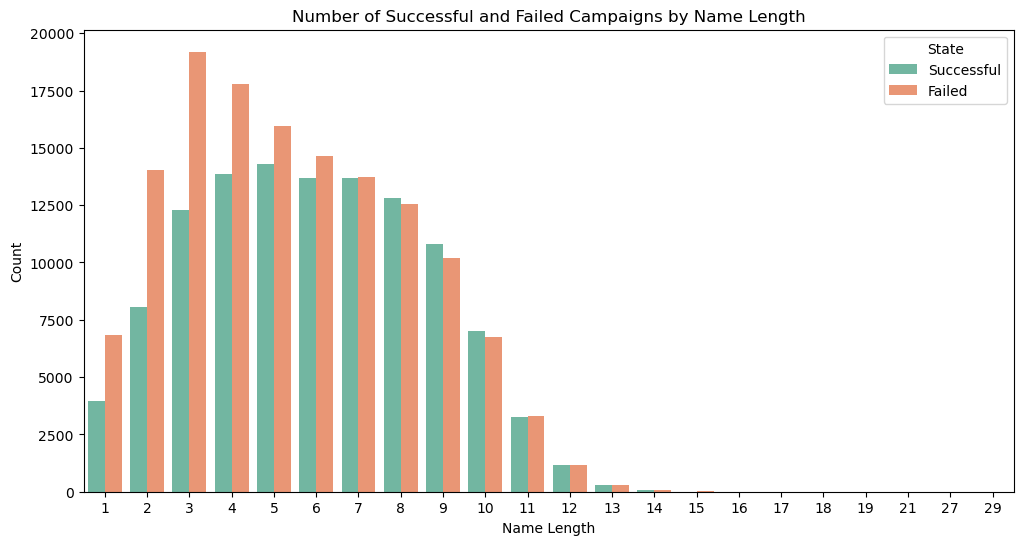

In [21]:
plt.figure(figsize=(12, 6))

# Define a custom hue order to match the legend labels
hue_order = ['Successful', 'Failed']

# Use the 'hue_order' parameter to specify the order of the hue (State) levels
sns.countplot(x='Name_word_count', hue='State', data=ks, palette='Set2', hue_order=hue_order)

plt.xlabel('Name Length')
plt.ylabel('Count')
plt.title('Number of Successful and Failed Campaigns by Name Length')

plt.legend(title='State', labels=['Successful', 'Failed'])
plt.show()

---

1. If started in US ...

2. If category is technology, then ...

3. If campaign is launched in September, then ...

4. If duration of campaign is shorter than 30 days, then ...

5. If the campaign name is shorter, then ...